# EEG analysis

The goal of this notebook is to analyze an EEG sample in order to understand more our dataset.

In [2]:
%matplotlib qt
import mne
import matplotlib.pyplot as plt
import numpy as np
import os

In this part, we used the standard montage "standard_1005" and we personalized it by adding the two last electrodes near the ears. Note that we needed to change channels names from our edf file to match it with standard montage.

In [3]:
from utils import rename_channel
folder = "subjects/S001" # Change the name here to analyze an other EEG
raws = [mne.io.read_raw_edf(file.path, preload=True) for file in os.scandir(folder) if "event" not in file.name]
raw_combined = mne.concatenate_raws(raws)
raw_combined.rename_channels(rename_channel)

Extracting EDF parameters from c:\Users\yassi\OneDrive\Documents\AI\MNE\subjects\S001\S001R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Extracting EDF parameters from c:\Users\yassi\OneDrive\Documents\AI\MNE\subjects\S001\S001R02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Extracting EDF parameters from c:\Users\yassi\OneDrive\Documents\AI\MNE\subjects\S001\S001R03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from c:\Users\yassi\OneDrive\Documents\AI\MNE\subjects\S001\S001R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from c:\Users\ya

<RawEDF | S001R01.edf, 64 x 259520 (1622.0 s), ~126.8 MiB, data loaded>

## Montage creation

According to the website, their montage is similar to the standard_1005. Therefore, we will use this montage.

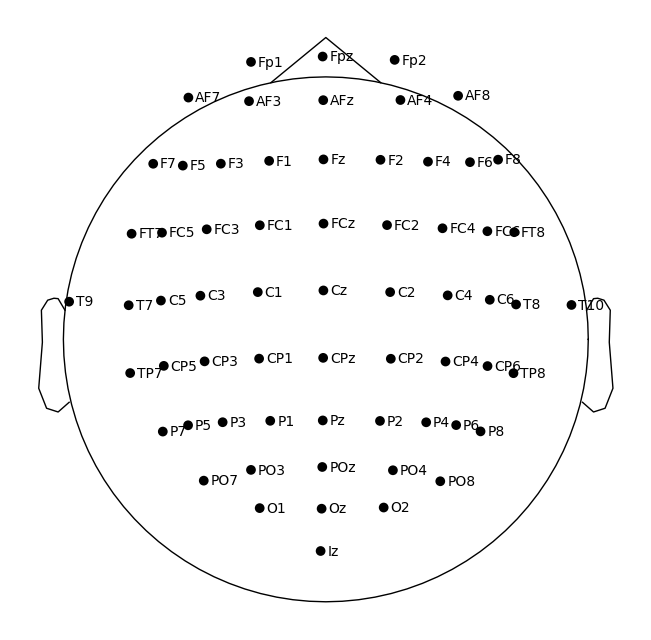

In [4]:
montage = mne.channels.make_standard_montage('standard_1005')
raw_combined.set_montage(montage)
raw_combined.plot_sensors(kind='topomap', show_names=True)

Our montage is shifted trhought y-axis. I didn't find a robust method to change the display. We will have to take into account this when we analyse the topo map.

Note that we can change the radius of the head showed

## II. Filter and referencing

In order to analyze our EEG, we need to filter noises and bad channels. Therefore, we will analyze the power spectral density. It will help us to identify bad channels. 

Filtering raw data in 14 contiguous segments
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 529 samples (3.306 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.0s finished


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Effective window size : 12.800 (s)
Plotting power spectral density (dB=True).


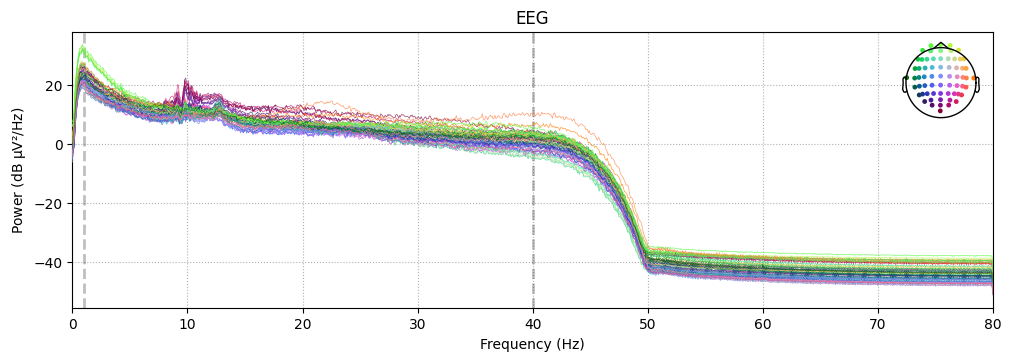

In [5]:
raw_combined.filter(l_freq=1., h_freq=40.)# Default values in most eeg preprocessing,, moreover, motor signals are between theses values
raw_combined.set_eeg_reference('average') # average across all channels
raw_combined.compute_psd().plot()


We filter our signals here to suppress artifacts. In order to do that, we will check the variance of our channels. Then for this, we will put a threshold (depending on the variance) and select channels that execeeds our threshold.

In [6]:
import numpy as np


data = raw_combined.get_data() # extract data shape (n_channels, n_samples)

variances = np.var(data, axis=1) # compute the variance
threshold = np.mean(variances) + 3 * np.std(variances) # set a threhold according to the variance
bad_idx = np.where(variances > threshold)[0] # find bad channels indices with thres
bad_channels = [raw_combined.ch_names[i] for i in bad_idx] # get bad channels with idx
print("Bad channels are: ", bad_channels)

Bad channels are:  ['Fp1', 'Fp2']


After marking bad channels, interpolate_bads() uses neighboring channel information to reconstruct and replace bad channel data. Here, we see that Fp1 and Fp2 are detected. This looks normal because they are placed near the eyes and therefore are affected by them

In [7]:
# Interpoler canaux mauvais
raw_combined.info['bads'] = bad_channels

raw_combined.interpolate_bads()

Setting channel interpolation method to {'eeg': 'spline'}.


Interpolating bad channels.
    Automatic origin fit: head of radius 95.5 mm
Computing interpolation matrix from 62 sensor positions
Interpolating 2 sensors


<RawEDF | S001R01.edf, 64 x 259520 (1622.0 s), ~126.8 MiB, data loaded>

Fp1, Fp2 are positioned near the eyes. Since our subject blinks and alternates between eyes closed and open, the signals from these channels are likely contaminated by these movements. The result is then not abnormal. We will perform an Independant Component Analysis (ICA)

## III. ICA

In [8]:



from mne.preprocessing import ICA

ica = ICA(n_components=20, random_state=97) #create components, default value for 64 is usually 20, fixed seed to not have random results everytime
ica.fit(raw_combined)

Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 6.8s.


Method,fastica
Fit parameters,algorithm=parallelfun=logcoshfun_args=Nonemax_iter=1000
Fit,22 iterations on raw data (259520 samples)
ICA components,20
Available PCA components,64
Channel types,eeg
ICA components marked for exclusion,—


We now have to analyze our components to spot the bad ones such as blinking eyes, muscles activity, noises ....

Creating RawArray with float64 data, n_channels=20, n_times=259520
    Range : 0 ... 259519 =      0.000 ...  1621.994 secs
Ready.
Using matplotlib as 2D backend.


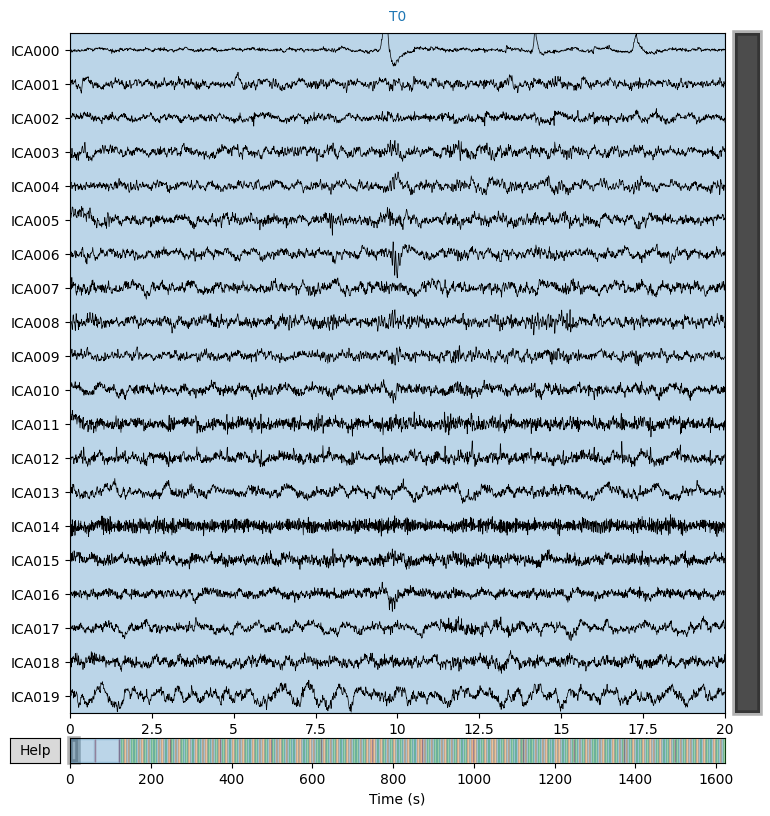

In [ ]:
ica.plot_components()             # Show topography of each IC
ica.plot_sources(raw_combined)


In [245]:
potential_bad_component = [0, 2, 18, 19, 15, 13, 14]

In [242]:
ica.plot_properties(raw_combined, picks=potential_bad_component)  # Show time series, PSD, etc.

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated


[<Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>]

We can automatize muscle detection with ica.

In [246]:
muscle_idx_auto, scores = ica.find_bads_muscle(raw_combined)
ica.plot_scores(scores, exclude=muscle_idx_auto)
print(
    f"Manually found muscle artifact ICA components:      {potential_bad_component}\n"
    f"Automatically found muscle artifact ICA components: {muscle_idx_auto}"
)

Effective window size : 12.800 (s)
Manually found muscle artifact ICA components:      [0, 2, 18, 19, 15, 13, 14]
Automatically found muscle artifact ICA components: [14, 15, 16]


THe goal is to spot component close to the eyes or that looks like noises.

In [247]:
ica.exclude = [0, 2, 14, 15, 16] # select components to exclude
raw_clean = ica.apply(raw_combined.copy()) # we use this in order to keep the raw before the application of the ica


Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 5 ICA components
    Projecting back using 64 PCA components


## IV. Epoch segmentation

Once, we cleaned our raw, we finally can use the epoch segmentation on our cleaned data. 

We need to separate our EEG signals according to the events. Fortunately, we don't have to find the event, they are already recorded with the files .event. We need to use the object *Epochs* for that. A good practice is to reject bad epochs thanks to a criteria such as a peak to peak amplitude (the difference between the maximum and minimum voltage values within a single epoch for one channel.). Here, we set this criteria at 150e-6. It is a common value according to the documentation of mne (https://mne.tools/stable/auto_tutorials/preprocessing/30_rejecting_bad_epochs.html#peak-to-peak-rejection)

In [248]:
import pandas as pd

events, event_id = mne.events_from_annotations(raw_clean) # the .event is automatically detected by mne
epochs = mne.Epochs(raw_clean, events, event_id=event_id,
                    tmin=-0.2, tmax=0.8, preload=True) # we take a small moments before the apparation of the event
reject_criteria = dict(eeg=250e-6)  # 150 µV peak-to-peak threshold
epochs_clean = epochs.copy().drop_bad(reject=reject_criteria) # drop epoch that doesnt satisfy this criteria

Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Not setting metadata
362 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 362 events and 161 original time points ...
14 bad epochs dropped
    Rejecting  epoch based on EEG : ['POz', 'PO4', 'PO8', 'O1', 'O2', 'Iz']
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['PO4', 'PO8', 'O2']
    Rejecting  epoch based on EEG : ['Fpz', 'AFz', 'AF4', 'F2', 'F4', 'F6']
    Rejecting  epoch based on EEG : ['Iz']
    Rejecting  epoch based on EEG : ['F5']
    Rejecting  epoch based on EEG : ['Iz']
    Rejecting  epoch based on EEG : ['PO4', 'PO8']
9 bad epochs dropped


Note that we create 30 epochs but kept only 17

Thanks to the epoch separation, we can now plot the average EEG amplitude per channel averaged over epochs and time.

In [249]:
import matplotlib.pyplot as plt
from mne.viz import plot_topomap

channel_means = {}
for condition in event_id:
    data = epochs[condition].get_data()  # (n_epochs, n_channels, n_times)
    mean_vals = data.mean(axis=0).mean(axis=1)  # mean over epochs and time, shape (n_channels,)
    channel_means[condition] = mean_vals

for cond, mean_values in channel_means.items():
    fig, ax = plt.subplots()
    plot_topomap(mean_values, epochs.info, axes=ax, show=False)
    ax.set_title(f'Mean amplitude - {cond}')
plt.show()

T0 shows a big brain activity in the center of the brain reflect the activation of medial motor and sensory region. T1 and T2 shows activity in the right somatosensory cortex (S1) and in the left somatosensory. Results looks okay because T0 is the concentration phase. Moreover, during the experiment, the subject can move both feets and fists so we should see activity in both section. 